# **Final Test**

  * You can use Colab or your local installation
  * Rename the notebook with your Surname
  * SEND THE .ipynb file to `marco.milanesio@univ-cotedazur.fr` 
  * **DEADLINE** 12-01-2021 at 23h59.

## Usual preamble to a `Spark` notebook on google.colab...

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
update-alternatives: error: error creating symbolic link '/etc/alternatives/java.dpkg-tmp': Permission denied
java version "1.8.0_45"
Java(TM) SE Runtime Environment (build 1.8.0_45-b14)
Java HotSpot(TM) 64-Bit Server VM (build 25.45-b02, mixed mode)


Let's load the data.


In [3]:
!ls

boston.csv  exam.ipynb


You should have now `boston.csv` in your folder.

## ... or continue from here if you run locally on your machine

## Housing prices in Boston

The goal is to predict the housing prices in the Boston area.

The data is as follows:
  * `crim` — per capita crime rate by town.
  * `zn` — proportion of residential land zoned for lots over 25,000 sq.ft.
  * `indus` — proportion of non-retail business acres per town.
  * `chas` — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  * `nox` — nitrogen oxides concentration (parts per 10 million).
  * `rm` — average number of rooms per dwelling.
  * `age` — proportion of owner-occupied units built prior to 1940.
  * `dis` — weighted mean of distances to five Boston employment centres.
  * `rad` — index of accessibility to radial highways.
  * `tax` — full-value property-tax rate per $10,000.
  * `ptratio` — pupil-teacher ratio by town.
  * `black` — 1000(Bk — 0.63)<sup>2</sup> where Bk is the proportion of blacks by town.
  * `lstat` — lower status of the population (percent).
  * `medv` — median value of owner-occupied homes in \$1000s. **This is the target variable.**

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

## 0 - Create a spark session named 'houses'

In [9]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory", "2g") \
    .appName("houses") \
    .getOrCreate()

## 1 - Load the `boston.csv` file into the session
Use proper values for `inferSchema` and `header`, depending on the file itself...

**CALL IT `bostondf`** Otherwise some code may not work later

In [11]:
bostondf = (spark
            .read
            .format("csv")
            .options(header=True, inferSchema=True)
            .load("boston.csv"))

## 2 - Print the dataframe schema

In [12]:
bostondf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



## 3 - Show the first 3 rows of the dataframe

In [13]:
bostondf.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|_c0|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|  1|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|  2|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|  3|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 3 rows



## 4 - Output basic stats on the dataset.

*hint*: for readability purposes you can `transpose` a description dataframe.


In [25]:
bostondf.toPandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
_c0,506.0,253.500000,146.213884,1.00000,127.250000,253.50000,379.750000,506.0000
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000


## 5 - Scatter Matrix (use pandas)

Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. `pandas` does it for us.


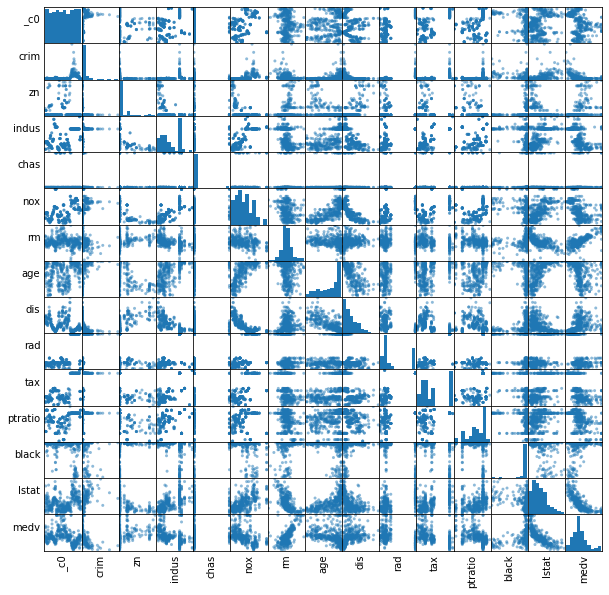

In [26]:
# DON"T CHANGE THIS. JUST RUN IT
import pandas as pd

numeric_features = [t[0] for t in bostondf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = bostondf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## 6 - Comment on the scatterplot

Add your considerations here.

## 7 - Compute all correlations with the target variable (`medv`)

*hint*: look at the `stat` attribute of the dataframe

## 8 - Data preparation

We keep all the variables, for now. **WHY?**

To prepare the data we need features and labels.
Being that data is numerical, we do not have to perform any encoding. Just build the `Vector`.

In [ ]:
from pyspark.ml.feature import VectorAssembler

input_columns = ...

features = VectorAssembler(inputCols=input_columns, outputCol='features')

v_df = ...
v_df.show(3)

Let's split the dataset into training and testing sets with a 70:30 ratio

In [ ]:
# DONT CHANGE THIS, Just RUN IT.
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

## 9 - Linear regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.regression).

Build a linear regression model to fit the data.
  * feature column: `features`
  * label column: `medv`
  * maxIter: 10
  * regParam: 0.3
  * elasticNetParam: 0.8  <- optional

Fit the model and print `coefficients` and `intercept`

In [ ]:
from pyspark.ml.regression import LinearRegression
lr = ...
lr_model = ...

## 10 - Summary and RMSE

Print the summary of the model, the `RMSE` and the `r2` errors

RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual `medv` value, such as mean, min and max.

What can you infer from this results? Is it good or is it bad?


## 11 - Predictions

Make preditions and evaluate the model (e.g., with `RMSE`). We will use a `RegressionEvaluator` for this.

In [ ]:
lr_predictions = ...
lr_predictions.select("prediction","medv","features").show(5)

In [ ]:
# DON'T TOUCH THIS. JUST RUN
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

In [ ]:
test_result = ...
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)


In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

trainingSummary.residuals.show()

We can use the model to make some predictions on the testing set.

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", "features").show()


## 12 - Decision tree regression and Gradient-boosted tree regression

Try to do the same thing with these 2 regressors.
Which will result better? 

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = 
dt_model = 
dt_predictions = 

dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

### Gradient-boosted tree regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor).

In [ ]:
from pyspark.ml.regression import GBTRegressor
gbt = 
gbt_model = 
gbt_predictions = 

gbt_predictions.select('prediction', 'medv', 'features').show(5)


In [ ]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)